In [3]:
#numpy
import numpy as np
from numpy.random import multivariate_normal #For later example

#advectionGP
from advectionGP.models import AdjointSecondOrderODEModel as ODEModel #Model module builds basic parts of the ODE problem, combines other classes into full model
 
from advectionGP.models import AdjointAdvectionDiffusionModel as PDEModel

from advectionGP.wind import WindSimple#Wind model

from advectionGP.sensors import FixedSensorModel #Builds sensor arrays to generate data for foward model or to generate observations for comparison
from advectionGP.kernels import EQ #Generates exponentiated quadratic kernel approximation
from advectionGP.test import TestKernels #Unit test model


#Plotting tools
import matplotlib.pyplot as plt

# ODE Example

In [11]:
avg=0.01 # time that an observation is taken for
tlocL = np.linspace(0,9.9,10) # observation start times
X= np.zeros((len(tlocL),2)) # initiate X
# Build sensor locations
X[:,0] = tlocL #lower time
X[:,1] = X[:,0]+avg # upper time

sensors = FixedSensorModel(X,0) # establish sensor model arguments are sensor locations and spatial averaging (not applicable in 1D case so set to 0)

### Generate forward model with parameter set p1=[0.8,5,-1]

In [12]:
k_0 = -1 #Diffusion coefficient
u=0.8
eta=5

p1 = [u,eta,k_0]

noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0],[10])# edges of the grid - in units of time
kForward = EQ(0.6, 4.0) # generate EQ kernel arguments are lengthscale and variance
res = [500] # grid size for time

In [13]:
m = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kForward,sensormodel=sensors,k_0=k_0,u=u,eta=eta) #initiate PDE model to build concentration

dt,dt2,Nt = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source
sourceGT=m.computeSourceFromPhi(z)# Compute ground truth source by approximating GP
#sourceGT = np.ones(m.resolution)  # Example constant source
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs ODE forward model
yTrain= m.computeObservations(addNoise='TRUE') # Compute observations with noise uses m.sensormodel for observation locations

### Infer Source with parameter set p1

In [14]:
#%%timeit
N_feat =200 #Number of features used to infer the source
kInverse = EQ(0.6, 4) # Initiate kernel for inverse problem
mInfer = ODEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=kInverse,sensormodel=sensors,k_0=p1[2],u=p1[0],eta=p1[1]) #Initiate new model for inference
mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ, covZ = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer = mInfer.computeSourceFromPhi(meanZ) # Generates estimated source using mean of the inferred distribution
concInfer=mInfer.computeConcentration(sourceInfer) # Generates estimated concentration from inferred source


Calculating Adjoints...
9/10 
Calculating Phis...
199/200 


### Plot source and output prediction

Note that both source and concentration inference are accurate.

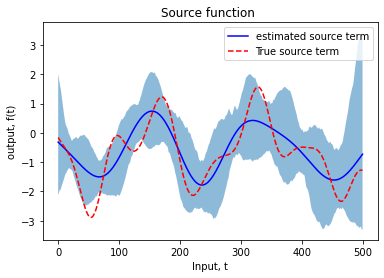

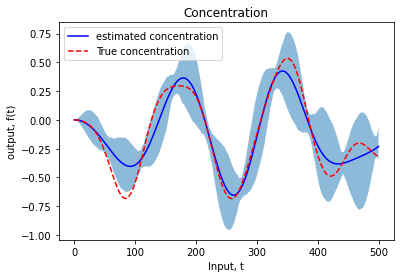

In [15]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ, covZ,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

### Infer source with parameter set p2=[3,1,-0.05]

In [16]:
#%%timeit
p2 = [3, 1,-0.05]
N_feat =200 #Number of features used to infer the source

mInfer.k_0=p2[2]
mInfer.u=p2[0]
mInfer.eta=p2[1]

mInfer.computeModelRegressors() # Compute regressor matrix 
meanZ2, covZ2 = mInfer.computeZDistribution(yTrain) # Infers z vector mean and covariance using regressor matrix
sourceInfer2 = mInfer.computeSourceFromPhi(meanZ2) # Generates estimated source using mean of the inferred distribution
concInfer2=mInfer.computeConcentration(sourceInfer2) # Generates estimated concentration from inferred source


Calculating Adjoints...
9/10 
Calculating Phis...
199/200 


### Plot source and output prediction

Note that both source inference is inaccurate and concentration inference is accurate.


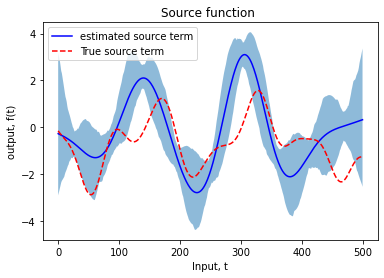

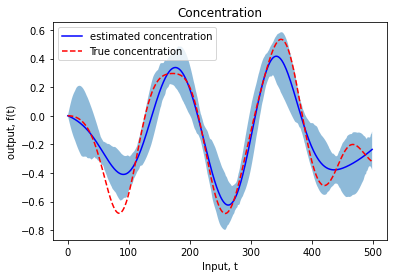

In [17]:
source_samples = []
conc_samples=[]    
for z_samp in np.random.multivariate_normal(meanZ2, covZ2,200):
    source_samples.append(mInfer.computeSourceFromPhi(z_samp))
    conc_samples.append(mInfer.computeConcentration(mInfer.computeSourceFromPhi(z_samp)))
source_samples=np.array(source_samples)
conc_samples=np.array(conc_samples)

source_lower_ci = np.percentile(source_samples,2.5,0)
source_upper_ci = np.percentile(source_samples,97.5,0)
source_mean = np.percentile(source_samples,50,0)

conc_lower_ci = np.percentile(conc_samples,2.5,0)
conc_upper_ci = np.percentile(conc_samples,97.5,0)
conc_mean = np.percentile(conc_samples,50,0)

xtest=np.arange(Nt)

#plt.figure(figsize=(15, 10))

plt.plot(xtest,sourceInfer2,'b-')
plt.plot(xtest,sourceGT,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,source_lower_ci,source_upper_ci,alpha=0.5)
plt.legend(labels=["estimated source term","True source term"])
plt.title("Source function ")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

#plt.figure(figsize=(15, 10))

plt.plot(xtest,concInfer2,'b-')
plt.plot(xtest,concTrain,'r--')

#plt.plot(xtest,source_samples.T,'g-',alpha=0.3)
#plt.fill_between(xtest,s_z_l,s_z_upper,alpha=0.5)
plt.fill_between(xtest,conc_lower_ci,conc_upper_ci,alpha=0.5)
plt.legend(labels=["estimated concentration","True concentration"])
plt.title("Concentration")
plt.xlabel("Input, t")
plt.ylabel("output, f(t)")
#plt.ylim([-5,5])
plt.savefig('NumberFeature%d.pdf' % N_feat)
plt.show()

# PDE Example

In [99]:
# generate sensor locations for training data with shape [total observations, 4], where each row has elements 
#[lower time location, upper time location, x location, y location]

tlocL = np.linspace(1,8,3) # lower time
xloc=np.linspace(3,7,5) # x locations
yloc=np.linspace(3,7,5) # y locations
sensN = len(xloc)*len(yloc) # total number of sensors 
obsN = len(tlocL) # total time points at which an observation is taken
X= np.zeros((obsN*sensN,4)) # obsN*sensN is total observations over all sensors and all times
# Build sensor locations
X[:,0] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[0] #lower time
X[:,2] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[1] # x location
X[:,3] = np.asarray(np.meshgrid(tlocL,xloc,yloc)).reshape(3,sensN*obsN)[2] # ylocation
X[:,1] = X[:,0]+1 # upper time

sensors = FixedSensorModel(X,1) # establish sensor model arguments are sensor locations and spatial averaging

In [159]:
k_0 = 0.1 #Diffusion
R=0.1
noiseSD = 0.05 #Observation noise
N_feat=2000 # number of features used to approximate ground truth GP
boundary = ([0,0,0],[100,10,10])# corners of the grid - in units of space
k = EQ(2, 2.0) # generate EQ kernel arguments are lengthscale and variance
res = [500,30,30] # grid size for time, x and y



windmodel=WindSimple(0.01,0.01) # establish fixed wind model
m = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #initiate PDE model to build concentration

dt,dx,dy,dx2,dy2,Nt,Nx,Ny = m.getGridStepSize() # useful numbers!

z=np.random.normal(0,1.0,N_feat) # Generate z to compute source

sourceGT=(m.computeSourceFromPhi(z))# Compute source

#sourceGT = np.zeros(m.resolution)
#sourceGT[:,20:30,20:30]=10

In [160]:
concTrain=m.computeConcentration(sourceGT) # Compute concentration - runs advection diffusion forward model
yTrain= m.computeObservations() # Compute observations with noise uses m.sensormodel for observation locations

## Infer source with parameters p1=[(0.01,0.01),0.1]

In [ ]:
N_feat =1000 #Number of features used to infer the source
k1 = EQ(1, 2.0) 
k2 = EQ(2, 2.0) 

mPDE = PDEModel(resolution=res,boundary=boundary,N_feat=N_feat,noiseSD=noiseSD,kernel=k1,sensormodel=sensors,windmodel=windmodel,k_0=k_0) #Initiate new model for inference
regressPDE = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE, covZPDE = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE = mPDE.computeSourceFromPhi(meanZPDE) # Generates estimated source using inferred distributio
concPDE = mPDE.computeConcentration(sourcePDE)
yOut = mPDE.computeObservations()

### MSE between ground truth source and inferred source

In [ ]:
np.mean((sourceGT-sourcePDE)**2)

### MSE between ground truth conc and inferred conc

In [ ]:
np.mean((concTrain-concPDE)**2)

### MSE between observations and inferred observations

In [ ]:
np.mean((yTrain-yOut)**2)

In [ ]:
plt.imshow(concTrain[30])
plt.colorbar()

In [ ]:
plt.imshow(concPDE[30])
plt.colorbar()

## Infer source with parameters p2 = [(0.000001,0.000001),0.0000001]

In [ ]:
N_feat =500 #Number of features used to infer the source
k1 = EQ(2, 2.0) 
k2 = EQ(2, 2.0) 

k_0=0.0000001
u=[]

windmodel2=WindSimple(0.000001,0.0000001) # establish fixed wind model

mPDE.windmodel=windmodel2
mPDE.u = mPDE.windmodel.getu(mPDE)
mPDE.k_0=k_0

regressPDE2 = mPDE.computeModelRegressors() # Compute regressor matrix
meanZPDE2, covZPDE2 = mPDE.computeZDistribution(yTrain) # Infers z vector mean and covariance
sourcePDE2 = mPDE.computeSourceFromPhi(meanZPDE2) # Generates estimated source using inferred distributio
concPDE2 = mPDE.computeConcentration(sourcePDE2)
yOut2 = mPDE.computeObservations()

### MSE between ground truth source and inferred source

In [ ]:
np.mean((sourceGT-sourcePDE2)**2)

### MSE between ground truth conc and inferred conc

In [ ]:
np.mean((concTrain-concPDE2)**2)

### MSE between observations and inferred observations

In [ ]:
np.mean((yTrain-yOut2)**2)

Note that source estimation and concentration estimation remain of similary quality despite different parameters.

In [ ]:
plt.imshow(concTrain[30])
plt.colorbar()

In [ ]:
plt.imshow(concPDE2[30])
plt.colorbar()